In [2]:
from extract_text import TextExtractor

/home/exouser/miniconda3/envs/medsyn-3-8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
impressions="right pleural effusion and no left pleural effusion"
output_folder = "/media/volume/gen-ai-volume/MedSyn/results/text_embed"  
file_name='test_rightpleur_noleft.npy'
text_extractor = TextExtractor(resume_model="/media/volume/gen-ai-volume/MedSyn/models/test_run2")
text_extractor.run(impressions, output_folder, file_name)

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of CXRBertModel were not initialized from the model checkpoint at microsoft/BiomedVLP-CXR-BERT-specialized and are newly initialized: ['classifier.bias

<All keys matched successfully>
(1, 192, 768)
Saved to: /media/volume/gen-ai-volume/MedSyn/results/text_embed/test_rightpleur_noleft.npy


In [5]:
from stage1 import run_diffusion_1
import accelerate
accelerate.state.AcceleratorState._shared_state.clear() # dirty hack to reset accelerator state
run_diffusion_1(input_folder="/media/volume/gen-ai-volume/MedSyn/results/text_embed", 
                output_folder= "/media/volume/gen-ai-volume/MedSyn/results/img_64_standard/test_rightpleur_noleft", 
                model_folder="/media/volume/gen-ai-volume/MedSyn/models/stage1", 
                attention_folder="/media/volume/gen-ai-volume/MedSyn/results/saliency_maps/test_rightpleur_noleft",
                dont_delete_folder="/media/volume/gen-ai-volume/MedSyn/results/img_64_standard",
                num_sample=1,
                noise_folder="/media/volume/gen-ai-volume/MedSyn/results/img_64_standard/saved_noise/test_rightpleur_noleft")

/home/exouser/MedsynBackend/src/stage1.py:1215: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path, map_location=map_location), s

loading low-res model...
File already exists: /media/volume/gen-ai-volume/MedSyn/results/img_64_standard/test_rightpleur_noleft/dont_delete_sample_0.npy
Pre-saved noise not found! Generating new fixed noise instead.
Low Resolution: 100%|██████████| 51/51 [00:15<00:00,  3.28it/s]
ATTENTION PATH:  /media/volume/gen-ai-volume/MedSyn/results/saliency_maps/test_rightpleur_noleft/20250210115832normalches_sample_0_attention.npy


/home/exouser/MedsynBackend/src/stage1.py:1343: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  flattened_maps = [torch.tensor(m).to("cpu") for maps in all_attention_maps for m in maps]


## Visualizing the saliency map generations

In [6]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.cm as cm

generated_filename = "test_rightpleur_noleft_sample_0.npy"
output_folder = "/media/volume/gen-ai-volume/MedSyn/results/img_64_standard/test_rightpleur_noleft"
image_path = os.path.join(output_folder, generated_filename)

generated_image = np.load(image_path)  # Shape: (C, D, H, W) or (C, num_slices, height, width)
print(f"Loaded image shape: {generated_image.shape}")  # Check image dimensions

if generated_image.shape[1] == 1:  # Only squeeze axis=1 if it's 1
    generated_image = np.squeeze(generated_image, axis=1)

print(f"Loaded image shape: {generated_image.shape}")  # Check image dimensions


Loaded image shape: (1, 1, 4, 64, 64, 64)
Loaded image shape: (1, 4, 64, 64, 64)


In [7]:
# Define attention map path (modify filename if needed)
attention_output_folder = "/media/volume/gen-ai-volume/MedSyn/results/saliency_maps/test_rightpleur_noleft"
attention_map_filename = "test_rightpleur_noleft_sample_0_attention.npy"  # Change if necessary
attention_map_path = os.path.join(attention_output_folder, attention_map_filename)
print(attention_map_path)

# Load the attention maps
if os.path.exists(attention_map_path):
    attention_maps = np.load(attention_map_path)  # Shape: (num_heads, Slices, Height, Width)
    print(f"Loaded attention map shape: {attention_maps.shape}")
    # Check if dimension 1 is an unnecessary singleton
    if attention_maps.shape[1] == 1:
        attention_maps = attention_maps.squeeze(1)  # Removes singleton dimension

    # Check final shape after squeeze
    print(f"Fixed attention map shape: {attention_maps.shape}")

else:
    print("Attention maps not found! Make sure they were saved.")
    attention_maps = None


/media/volume/gen-ai-volume/MedSyn/results/saliency_maps/test_rightpleur_noleft/test_rightpleur_noleft_sample_0_attention.npy
Loaded attention map shape: (4, 1, 1280, 64, 8, 8)
Fixed attention map shape: (4, 1280, 64, 8, 8)


In [8]:
def overlay_attention_on_slice(image_slice, attention_slice_resized, alpha=0.5):
    """
    Overlay attention map on a single DICOM slice while ensuring correct alignment.
    """
    # Normalize image slice to [0, 255]
    image_slice = (image_slice - np.min(image_slice)) / (np.max(image_slice) - np.min(image_slice) + 1e-8)
    image_slice = (image_slice * 255).astype(np.uint8)

    # Normalize attention slice and convert to uint8
    attention_slice_resized = (attention_slice_resized - np.min(attention_slice_resized)) / \
                              (np.max(attention_slice_resized) - np.min(attention_slice_resized) + 1e-8)

    # ✅ **Use Matplotlib's reversed colormap**
    colormap = cm.get_cmap('jet')  # 🔥 `_r` reverses the colormap (jet_r = reversed jet)
    heatmap = colormap(attention_slice_resized)[:, :, :3]  # Convert to RGB without alpha

    # ✅ Convert grayscale image to 3-channel for blending
    image_slice_colored = cv2.cvtColor(image_slice, cv2.COLOR_GRAY2BGR)

    # Convert heatmap (float 0-1) to 255-based uint8
    heatmap = (heatmap * 255).astype(np.uint8)

    # Blend
    overlay = cv2.addWeighted(image_slice_colored, 1 - alpha, heatmap, alpha, 0)

    return overlay


/tmp/ipykernel_6538/1206481574.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('jet')  # 🔥 `_r` reverses the colormap (jet_r = reversed jet)


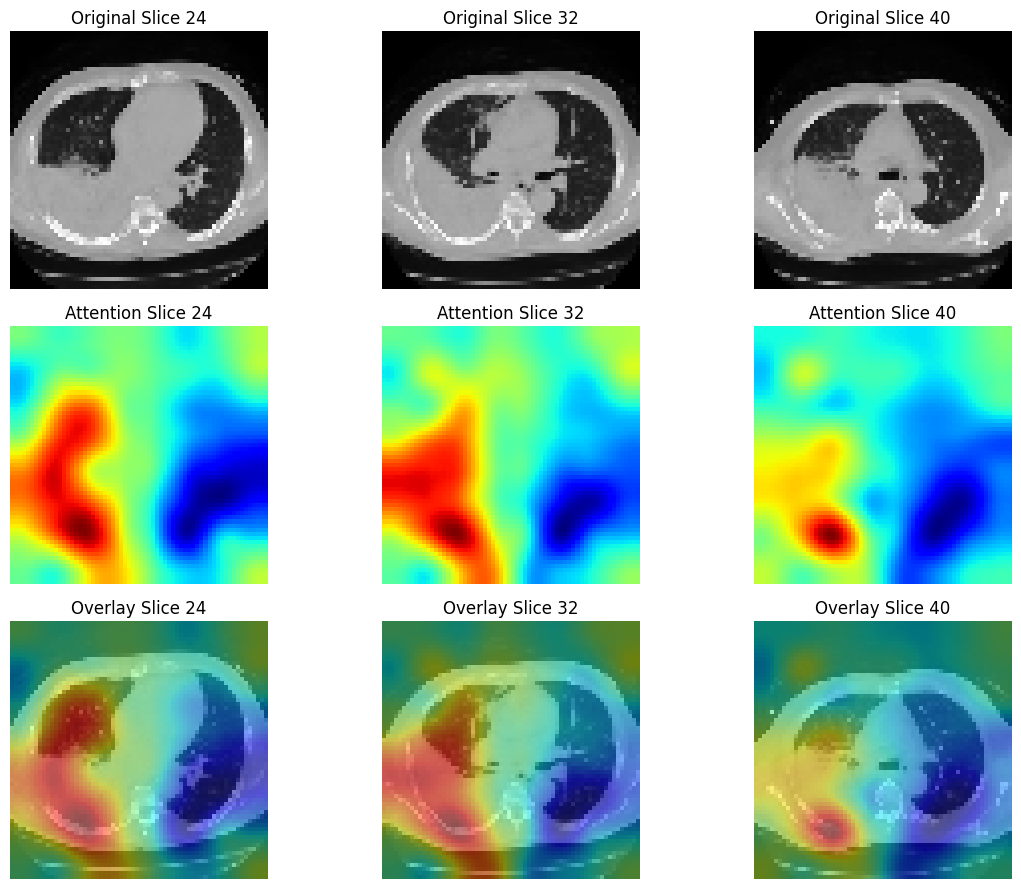

In [9]:
# Select slices for visualization
num_slices = generated_image.shape[2]  # Depth of the image (D)
selected_slices = [24, num_slices // 2, 40]  # Select three slices

plt.figure(figsize=(12, 9))

for i, slice_idx in enumerate(selected_slices):
    original_slice = generated_image[0, :, slice_idx, :, :]  # Extract original image slice
    
    # Ensure grayscale shape (H, W)
    if len(original_slice.shape) > 2:
        original_slice = original_slice[0]  # Take the first channel if multi-channel

    # Extract and process attention slice
    attention_slice = attention_maps[:, 0, slice_idx, :, :].mean(axis=0)  # Average across attention heads

    # ⚠️ Ensure the attention slice is squeezed properly to avoid errors
    if len(attention_slice.shape) > 2:
        attention_slice = attention_slice.squeeze()

    # Resize attention map to match original image dimensions (64x64)
    attention_slice_resized = cv2.resize(attention_slice, (64, 64), interpolation=cv2.INTER_CUBIC)
    attention_slice_resized = np.flipud(attention_slice_resized)  # Flip upside down

    # Flip images upside down
    original_slice = np.flipud(original_slice)
    # attention_slice_resized = np.flipud(attention_slice_resized)
    # Overlay attention
    overlay = overlay_attention_on_slice(original_slice, attention_slice_resized)
    
    # ✅ Display Original Image & Heatmap Side by Side
    plt.subplot(3, len(selected_slices), i + 1)
    plt.imshow(original_slice, cmap="gray")
    plt.title(f"Original Slice {slice_idx}")
    plt.axis("off")

    # ✅ Display Heatmap
    plt.subplot(3, len(selected_slices), i + 1 + len(selected_slices))
    plt.imshow(attention_slice_resized, cmap="jet")
    plt.title(f"Attention Slice {slice_idx}")
    plt.axis("off")

    # ✅ Display Overlay
    plt.subplot(3, len(selected_slices), i + 1 + 2 * len(selected_slices))
    plt.imshow(overlay, cmap="gray")
    plt.title(f"Overlay Slice {slice_idx}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [29]:
from stage2 import run_diffusion_2
import accelerate
accelerate.state.AcceleratorState._shared_state.clear() # dirty hack to reset accelerator state

run_diffusion_2(input_folder="/media/volume/gen-ai-volume/MedSyn/results/img_64_standard", 
                        output_folder="/media/volume/gen-ai-volume/MedSyn/results/img_256_standard", 
                        model_folder="/media/volume/gen-ai-volume/MedSyn/models/stage2",
                        filename="test_rightpleur_noleft.npy",
                        num_series_exists=0)

Number of parameters: 54307908
Map Location: cuda
Model path: /media/volume/gen-ai-volume/MedSyn/models/stage2/1000_ckpt/pytorch_model.bin


/home/exouser/MedsynBackend/src/stage2.py:1110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path, map_location=map_location), s

found 2 videos as gif files at /media/volume/gen-ai-volume/MedSyn/results/img_64_standard
loading model...
Load accelerator state: /media/volume/gen-ai-volume/MedSyn/models/stage2/1000_ckpt
training model...
num_samples: 1
High Resolution: 100%|██████████| 21/21 [01:25<00:00,  4.09s/it]
num_samples: 1
High Resolution: 100%|██████████| 21/21 [01:25<00:00,  4.09s/it]


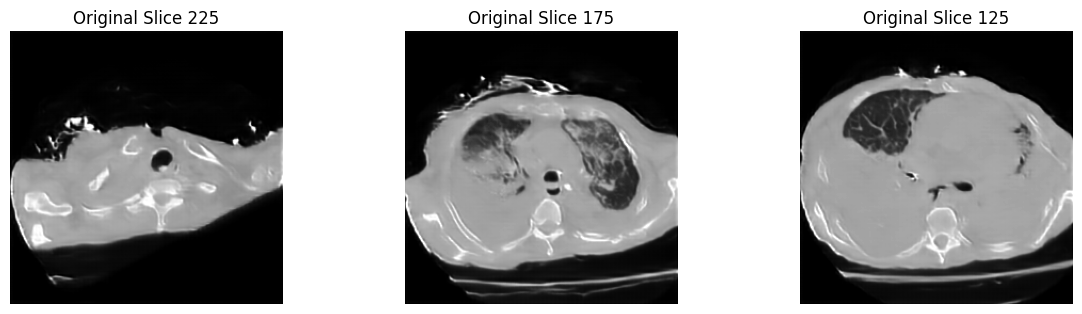

In [32]:
import nibabel as nib 

generated_highres_filename = "test_rightpleur_noleft_sample_0.nii.gz"
output_folder = "/media/volume/gen-ai-volume/MedSyn/results/img_256_standard/"
image_path = os.path.join(output_folder, generated_highres_filename)

nii_img = nib.load(image_path)

# Convert NIfTI to NumPy array
nii_data = nii_img.get_fdata()  # Shape: (depth, height, width)
nii_data.shape

num_slices_high_res = nii_data.shape[2]
selected_slices_high_res = [225, 175, 125]  # Select three slices

plt.figure(figsize=(12, 9))

for i, slice_idx in enumerate(selected_slices_high_res):
    original_slice = nii_data[:, :, slice_idx]  # Extract original image slice
    
    # Ensure grayscale shape (H, W)
    if len(original_slice.shape) > 2:
        original_slice = original_slice[:, :, 0]  # Take the first channel if multi-channel
        
    # Flip images upside down
    original_slice = (np.rot90(original_slice))
    
    # ✅ Display Original Image & Heatmap Side by Side
    plt.subplot(3, len(selected_slices), i + 1)
    plt.imshow(original_slice, cmap="gray")
    plt.title(f"Original Slice {slice_idx}")
    plt.axis("off")

plt.tight_layout()
plt.show()

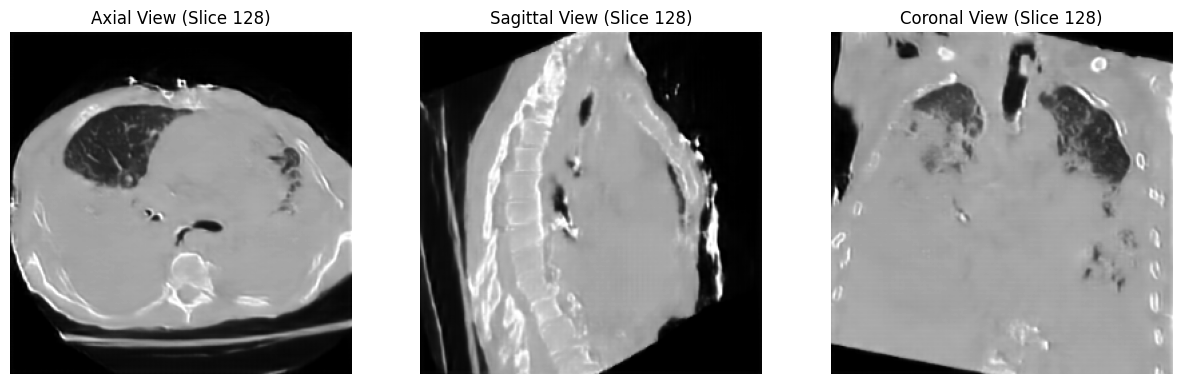

In [ ]:
import nibabel as nib 

generated_highres_filename = "test_rightpleur_noleft_sample_0.nii.gz"
output_folder = "/media/volume/gen-ai-volume/MedSyn/results/img_256_standard/"
image_path = os.path.join(output_folder, generated_highres_filename)

nii_img = nib.load(image_path)

# Convert NIfTI to NumPy array
nii_data = nii_img.get_fdata()  # Shape: (depth, height, width)

# Get middle slices for each view
axial_idx = nii_data.shape[2] // 2 
sagittal_idx = nii_data.shape[0] // 2 
coronal_idx = nii_data.shape[1] // 2 

# Apply rotation and flipping to correct orientation
axial_slice = np.rot90(np.fliplr(nii_data[:, :, axial_idx]))  # Axial (Top-Down)
sagittal_slice = np.rot90(np.fliplr(nii_data[sagittal_idx, :, :]))  # Sagittal (Side)
coronal_slice = np.rot90(np.fliplr(nii_data[:, coronal_idx, :]))  # Coronal (Front)

# ✅ FIXED: Swap labels for **Axial** and **Sagittal**
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Corrected Axial View
axes[0].imshow(axial_slice, cmap="gray", origin="lower")
axes[0].set_title(f"Axial View (Slice {axial_idx})")
axes[0].axis("off")

# Corrected Sagittal View
axes[1].imshow(sagittal_slice, cmap="gray", origin="lower")
axes[1].set_title(f"Sagittal View (Slice {sagittal_idx})")
axes[1].axis("off")

# Coronal View (Remains Correct)
axes[2].imshow(coronal_slice, cmap="gray", origin="lower")
axes[2].set_title(f"Coronal View (Slice {coronal_idx})")
axes[2].axis("off")

plt.show()

/tmp/ipykernel_6538/1206481574.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('jet')  # 🔥 `_r` reverses the colormap (jet_r = reversed jet)


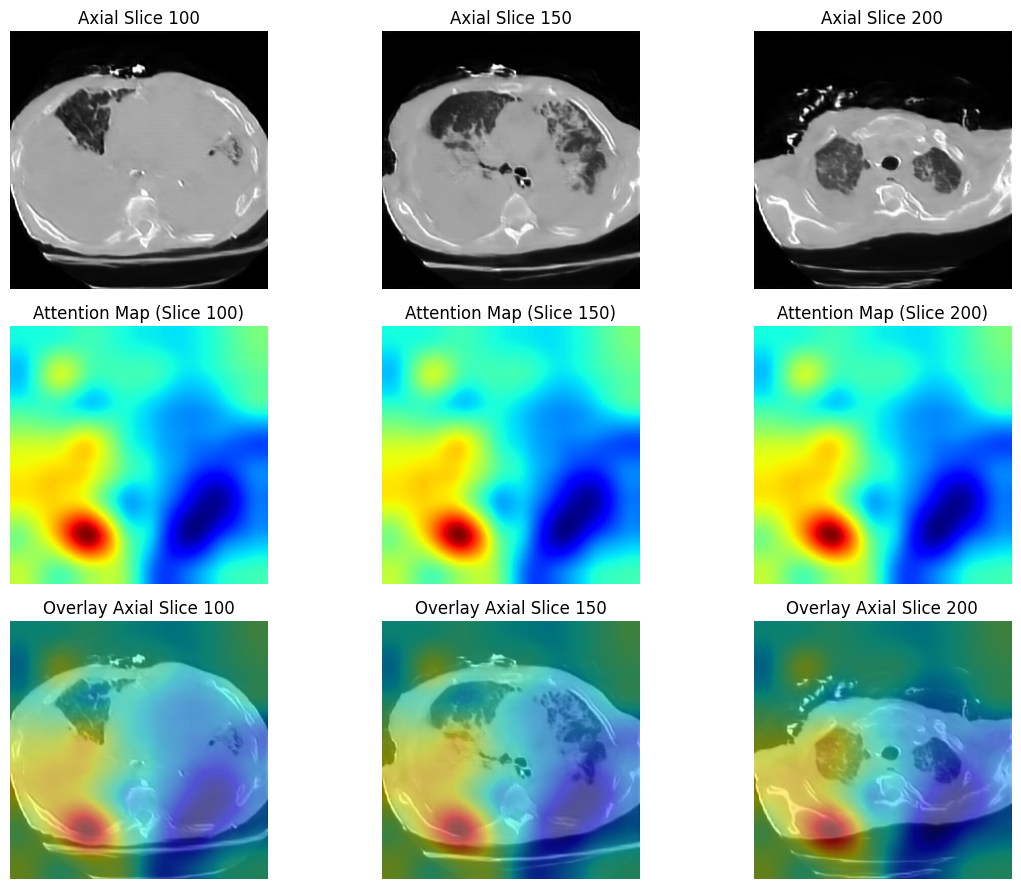

In [13]:
# Ensure selected slices exist
num_slices_high_res = nii_data.shape[0]  # Depth (D)
selected_slices = [100, 150, 200]  # Select three slices

plt.figure(figsize=(12, 9))

for i, axial_idx in enumerate(selected_slices):
    if axial_idx >= num_slices_high_res:
        continue
    original_slice = np.rot90(np.fliplr(nii_data[:, :, axial_idx]))  # Extract original image slice
    
    # Ensure grayscale shape (H, W)
    if len(original_slice.shape) > 2:
        original_slice = original_slice[0]  # Take the first channel if multi-channel

    attention_slice_resized = cv2.resize(attention_slice_resized, (256, 256), interpolation=cv2.INTER_CUBIC)  # **New Resize**

    # Flip images upside down
    original_slice = np.flipud(original_slice)

    # Overlay attention map on the high-res slice
    overlay = overlay_attention_on_slice(original_slice, attention_slice_resized)

   
    # ✅ Display Original Image & Heatmap Side by Side
    plt.subplot(3, len(selected_slices), i + 1)
    plt.imshow(original_slice, cmap="gray")
    plt.title(f"Axial Slice {axial_idx}")  # ✅ FIX: Use axial_idx instead of slice_idx
    plt.axis("off")

    # ✅ Display Heatmap (Now 256×256)
    plt.subplot(3, len(selected_slices), i + 1 + len(selected_slices))
    plt.imshow(attention_slice_resized, cmap="jet")
    plt.title(f"Attention Map (Slice {axial_idx})")  # ✅ FIX: Use axial_idx
    plt.axis("off")

    # ✅ Display Overlay
    plt.subplot(3, len(selected_slices), i + 1 + 2 * len(selected_slices))
    plt.imshow(overlay, cmap="gray")
    plt.title(f"Overlay Axial Slice {axial_idx}")  # ✅ FIX: Use axial_idx
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
from dicom_helpers import nifti_to_dicom

FILES_FOLDER = "/media/volume/gen-ai-volume/MedSyn/results/"
foldername = "test_rightpleur_noleft"
filename = "test_rightpleur_noleft"
sample_number = "0"
num_series_exists = 0
heatmap_npy_path = FILES_FOLDER + "saliency_maps/"+foldername+"/"+foldername+"_sample_"+sample_number+"_attention.npy"

nifti_file = os.path.join(FILES_FOLDER,"img_256_standard",filename+"_sample_" + str(num_series_exists) + ".nii.gz")
output_folder = os.path.join(FILES_FOLDER,"dicom",filename+"_sample_" + str(num_series_exists))


nifti_to_dicom(nifti_file=nifti_file,
                output_folder=output_folder,
                series_description="right pleural effusion, no left",                      
                series_instance_uid="000000000",
                study_instance_uid="01010101",
                patient_name="kkkkkk",
                patient_id="01010101")

Store DICOM files in Folder: /media/volume/gen-ai-volume/MedSyn/results/dicom/test_rightpleur_noleft_sample_0


/home/exouser/miniconda3/envs/medsyn-3-8/lib/python3.8/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '01010101'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/exouser/miniconda3/envs/medsyn-3-8/lib/python3.8/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '000000000'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)


Conversion complete. DICOM files are saved in /media/volume/gen-ai-volume/MedSyn/results/dicom/test_rightpleur_noleft_sample_0


In [41]:
from scipy.ndimage import zoom
import pydicom

ct_scan_folder = FILES_FOLDER + "dicom/"+foldername+"_sample_"+sample_number
oiverlay_path = foldername+"_sample_"+sample_number

dicom_output_folder = os.path.join(FILES_FOLDER, "dicom_overlays", oiverlay_path)
os.makedirs(dicom_output_folder, exist_ok=True)

# Load the heatmap from .npy
heatmap_data = np.load(heatmap_npy_path)  # Shape: (num_heads, 1, num_slices, H, W)
print(f"✅ Loaded heatmap: {heatmap_data.shape}")

# Remove singleton dimension if necessary
if heatmap_data.shape[1] == 1:
    heatmap_data = np.squeeze(heatmap_data, axis=1)  # Shape: (num_heads, num_slices, H, W)

# Average over attention heads
heatmap_data = heatmap_data.mean(axis=0)  # Shape: (num_slices, H, W)

# List all CT scan slices
dicom_files = sorted([f for f in os.listdir(ct_scan_folder) if f.endswith(".dcm")])
num_ct_slices = len(dicom_files)

if heatmap_data.shape[1] == 1:
    heatmap_data = np.squeeze(heatmap_data, axis = 1)

heatmap_data = heatmap_data.mean(axis=0)
heatmap_slices = heatmap_data.shape[0]

if heatmap_slices != num_ct_slices:
    print(f"🔄 Resizing heatmap slices from {heatmap_slices} → {num_ct_slices}")
    resized_heatmap = []
    
    for i in range(num_ct_slices):
        # Compute corresponding slice in heatmap
        slice_idx = int(i * (heatmap_slices / num_ct_slices))  # Map new index to old index range
        attention_slice = heatmap_data[slice_idx, :, :]

        # ⚠️ Ensure the attention slice is squeezed properly to avoid errors
        if len(attention_slice.shape) > 2:
            attention_slice = attention_slice.squeeze()

        # Resize the attention map to match original CT slice resolution
        attention_slice_resized = cv2.resize(attention_slice, (256, 256), interpolation=cv2.INTER_CUBIC)

        # Store the resized heatmap slice
        resized_heatmap.append(attention_slice_resized)

    heatmap_data = np.array(resized_heatmap)  # Convert back to NumPy array

# Process each DICOM slice
dicom_list = []
for i, dicom_filename in enumerate(dicom_files):
    dicom_path = os.path.join(ct_scan_folder, dicom_filename)
    ds = pydicom.dcmread(dicom_path)

    # Read the CT image
    ct_image = ds.pixel_array.astype(np.float32)
    ct_image = (ct_image - np.min(ct_image)) / (np.max(ct_image) - np.min(ct_image))  # Normalize

    # Read the corresponding heatmap slice
    heatmap_slice = heatmap_data[i, :, :]
    heatmap_slice = cv2.resize(heatmap_slice, (ct_image.shape[1], ct_image.shape[0]), interpolation=cv2.INTER_CUBIC)
    heatmap_slice = (heatmap_slice - np.min(heatmap_slice)) / (np.max(heatmap_slice) - np.min(heatmap_slice))  # Normalize

    # Overlay heatmap onto CT scan (blend using transparency)
    overlayed_image = (ct_image * 0.7 + heatmap_slice * 0.3)  # Adjust blending ratio
    overlayed_image = (overlayed_image * 255).astype(np.uint8)

    # Update DICOM metadata
    ds.PixelData = overlayed_image.tobytes()
    ds.Rows, ds.Columns = overlayed_image.shape
    ds.SeriesDescription = "CT Scan with Attention Overlay"
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()

    # Save the new DICOM slice
    output_dicom_path = os.path.join(dicom_output_folder, f"slice_{i:03d}.dcm")
    ds.save_as(output_dicom_path)
    dicom_list.append(output_dicom_path)

print(f"✅ Overlay process complete. DICOM saved at {dicom_output_folder}")

✅ Loaded heatmap: (4, 1, 1280, 64, 8, 8)
🔄 Resizing heatmap slices from 64 → 256


/home/exouser/miniconda3/envs/medsyn-3-8/lib/python3.8/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '000000000'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)


✅ Overlay process complete. DICOM saved at /media/volume/gen-ai-volume/MedSyn/results/dicom_overlays/test_rightpleur_noleft_sample_0
